# Predicting Horse Racing Results
BA Report (August 2020) <br>
Andrew Woon
## 3. Modelling

### 3.1 Feature engineering pipeline
Generate features dataset to be used in modelling, summarising processes developed during EDA into a single pipeline

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import re

In [2]:
df_horseform = pd.read_csv("../2. Data/stg_horseform.csv")
df_horseinfo = pd.read_csv("../2. Data/stg_horseinfo.csv")
df_overseas = pd.read_csv("../2. Data/stg_overseas.csv")
df_races = pd.read_csv("../2. Data/hkjc-races3.csv")

C:\Users\andyw\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df_horseform['date'] = df_horseform['date'].apply(lambda x: pd.to_datetime(x, format = '%d/%m/%Y') \
                                                  if len(x) == 10 else pd.to_datetime(x, format = '%d/%m/%y'))
df_horseform['rating'] = df_horseform['rating'].apply(lambda x: int(x) if re.search(r'\d+',x) else None)
df_horseform['draw'] = df_horseform['draw'].apply(lambda x: int(x) if re.search(r'\d+',x) else None)
df_horseform = df_horseform.drop(columns=['race_id'])

#### 3.1.1 Local and Overseas Races
Generate features using data from both local and overseas races
- `prev_placing_no_ewa3` - exponential weighted average for placing number
- `prev_lbw_no_ewa3` - exponential weighted average for length behind winner
- `prev_win_odds_2` - exponential weighted average for win odds

In [4]:
df_overseasform = pd.merge(df_overseas, df_horseinfo[['horse_id', 'overseas_url']], 
                           on ='overseas_url', how = 'inner')

df_overseasform['date'] = df_overseasform['date'].apply(lambda x: pd.to_datetime(x, format = '%Y-%m-%d'))

df_horseform['local'] = 1
df_overseasform['local'] = 0

col_names = ['horse_id', 'date', 'placing_no', 'win_odds', 'lbw_no']
df_horseform_m = df_horseform[col_names]
df_overseasform_m = df_overseasform[['horse_id', 'date', 'placing_no','win_odds', 'margin_no']]
df_overseasform_m.columns = col_names

df_form = pd.concat([df_horseform_m,df_overseasform_m])
df_form = df_form.sort_values(['horse_id','date'])

In [5]:
df_form['placing_no_ewa3'] = df_form.groupby(['horse_id'])['placing_no'] \
                                   .transform(lambda x: x.ewm(span=3).mean().round(2))
df_form['lbw_no_ewa3'] = df_form.groupby(['horse_id'])['lbw_no'] \
                                   .transform(lambda x: x.ewm(span=3).mean().round(2))
df_form['win_odds_ewa2'] = df_form.groupby(['horse_id'])['win_odds'] \
                                   .transform(lambda x: x.ewm(span=2).mean().round(2))

next_race = list(df_form.columns[df_form.columns.str.contains('ewa')])

df_form = df_form.assign(**{f'prev_{col}': df_form.groupby(['horse_id'])[col].shift(1) \
                   for col in next_race})

In [6]:
df_races['horse_id'] = df_races['horse_url'].apply(lambda x: x[53:66])
df_races['date'] = df_races['date'].apply(lambda x: pd.to_datetime(x, format = '%d/%m/%Y'))
df_races['race_id'] = df_races.groupby(['date', 'venue','race_no']).ngroup()

#### 3.1.2 Local Race Features
Generate features from local races only
- `prev_total_winrate` - overall horse win rate
- `prev_total_placerate` - overall horse place rate 
- `prev_course_grp_winrate` - horse win rate by course group
- `prev_course_grp_placerate` - horse place rate by course group
- `prev_rel_avg_diff_ewa2` - exponential weighted average of relative speed difference grouped by distance
- `prev_rating_diff` - rating difference versus previous race
- `prev_jockey_winrate` - jockey win rate
- `prev_jockey_placerate` - jockey place rate
- `prev_jockey_placing_ewa10` - exponential weighted average of jockey placing
- `draw` - draw for current race

In [7]:
df_local = pd.merge(df_horseform[df_horseform['venue'].isin(['ST','HV'])], 
                    df_races[['horse_id', 'date', 'race_id', 'race_no']], on = ['horse_id', 'date'], how= 'left')

In [8]:
df_local['local_win'] = (df_local['placing_no'] == 1) * 1
df_local['local_place'] = (df_local['placing_no'] <= 3) * 1
df_local['local_top5'] = (df_local['placing_no'] <= 5) * 1

def group_placing(df, prefix, grouping=None):
    horse_grp = ['horse_id'] + grouping if grouping else ['horse_id']
    df = df.sort_values(horse_grp + ['date'])
    df[f'{prefix}_races'] = df.groupby(horse_grp).cumcount()+1
    df[f'{prefix}_winrate'] = round(df.groupby(horse_grp)['local_win'].cumsum() / df[f'{prefix}_races'],2)
    df[f'{prefix}_placerate'] = round(df.groupby(horse_grp)['local_place'].cumsum() / df[f'{prefix}_races'],2)    
    return df

In [9]:
df_local = group_placing(df_local, 'total')
df_local = group_placing(df_local, 'course_grp', ['course_group'])

In [10]:
df_local['speed'] = df_local['distance'] / df_local['finish_time_s']

speed_grouping = ['horse_id', 'distance']

df_local = df_local.sort_values(speed_grouping +['date'])
df_local['speed_counter']= df_local['speed'].apply(lambda x: 0 if pd.isnull(x) else 1)

df_local['spd_dist'] = round(df_local.groupby(speed_grouping)['speed'].cumsum() / \
                        (df_local.groupby(speed_grouping)['speed_counter'].cumsum()), 2)
df_local['spd_dist'] = df_local.groupby(speed_grouping)['spd_dist'].ffill()
df_local.drop(columns=['speed_counter'], inplace=True)

df_local['spd_dist_avg'] = df_local.groupby(['distance','date'])['speed'] \
                            .transform(lambda x: round(x.mean(),2))

df_local['rel_spd_dist_diff'] = df_local['speed'] - df_local['spd_dist_avg']

df_local['rel_spd_dist_diff_ewa2'] = df_local.groupby(speed_grouping)['rel_spd_dist_diff'] \
                                   .transform(lambda x: x.ewm(span=2).mean().round(2))

In [11]:
prev_race = ['rating', 'rel_spd_dist_diff', 'rel_spd_dist_diff_ewa2']

prev_race_null = ['total_races', 'total_winrate', 'total_placerate',
           'course_grp_races', 'course_grp_winrate', 'course_grp_placerate']

df_local = df_local.sort_values(['horse_id', 'date'])
df_local = df_local.assign(**{f'prev_{col}': df_local.groupby(['horse_id'])[col].shift(1) \
                       for col in prev_race})

df_local = df_local.assign(**{f'prev_{col}': df_local.groupby(['horse_id'])[col].shift(1).fillna(0) \
                       for col in prev_race_null})

In [12]:
df_local['rating_diff'] = df_local['rating'] - df_local['prev_rating']

In [13]:
df_jockey = df_local[(df_local['date']>'2016-09-01')] \
            [['horse_id', 'date', 'jockey', 'placing_no', 'local_win', 'local_place']]

df_jockey['jockey'] = df_jockey['jockey'].fillna('N/A')
df_jockey = df_jockey.sort_values(['jockey', 'date'])

df_jockey['jockey_races'] = df_jockey.groupby(['jockey']).cumcount()+1
df_jockey['jockey_winrate'] = round(df_jockey.groupby(['jockey'])['local_win'].cumsum() / df_jockey['jockey_races'],2)
df_jockey['jockey_placerate'] = round(df_jockey.groupby(['jockey'])['local_place'].cumsum() / df_jockey['jockey_races'],2)

df_jockey['jockey_placing_ewa10'] = df_jockey.groupby('jockey')['placing_no'] \
                                           .transform(lambda x: x.ewm(span=10).mean().round(2))

df_jockey = df_jockey.assign(**{f'prev_{col}': df_jockey.groupby(['jockey'])[col].shift(1).fillna(0) \
                       for col in list(df_jockey.columns[df_jockey.columns.str.startswith('jockey_')])})

In [14]:
from functools import reduce

merge_dfs = [df_local, 
             df_form[['horse_id', 'date', 'prev_placing_no_ewa3', 'prev_lbw_no_ewa3', 'prev_win_odds_ewa2']],
             df_jockey[['horse_id', 'date', 'prev_jockey_winrate', 'prev_jockey_placerate', 'prev_jockey_placing_ewa10']]]

df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['horse_id', 'date'],
                                            how='left'), merge_dfs)

In [15]:
features = ['draw', 'prev_total_winrate', 'prev_total_placerate', 
           'prev_course_grp_winrate', 'prev_course_grp_placerate',
           'prev_rel_spd_dist_diff_ewa2', 'rating_diff',
           'prev_placing_no_ewa3', 'prev_lbw_no_ewa3', 'prev_win_odds_ewa2',
           'prev_jockey_winrate', 'prev_jockey_placerate', 'prev_jockey_placing_ewa10']

#### 3.1.3 Null handling
- Difference and rate columns fill nulls with 0
- Exponential weighted average fill nulls with mean
- Nulls in draw will have full row dropped, as withdrawn horses do not participate in races

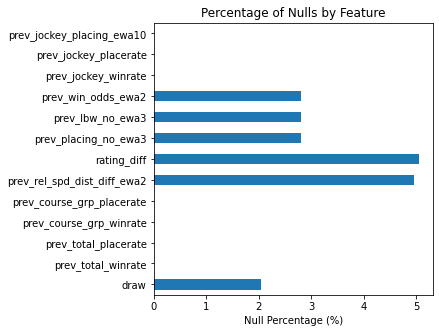

In [16]:
null_features = df_merged[(df_merged['date']>'2016-09-01')][features].isnull().sum() \
                    / len(df_merged[(df_merged['date']>'2016-09-01')]) * 100

fig, ax = plt.subplots(figsize=(5,5))

null_features.plot.barh()
plt.title('Percentage of Nulls by Feature')
plt.xlabel('Null Percentage (%)')
plt.show()

In [17]:
df_merged[df_merged['draw'].isna()]['placing'].unique()

array(['WV', 'WV-A', 'WX-A', 'WX', 'WXNR'], dtype=object)

In [18]:
df_merged = df_merged.dropna(subset=['draw'])

In [19]:
null_0 = ['rating_diff','prev_rel_spd_dist_diff_ewa2']
df_merged = df_merged.assign(**{f'{col}': df_merged[col].fillna(0) \
                       for col in null_0})

null_mean = ['prev_win_odds_ewa2', 'prev_lbw_no_ewa3', 'prev_placing_no_ewa3']
df_merged = df_merged.assign(**{f'{col}': df_merged[col].fillna(df_merged[col].mean()) \
                       for col in null_mean})

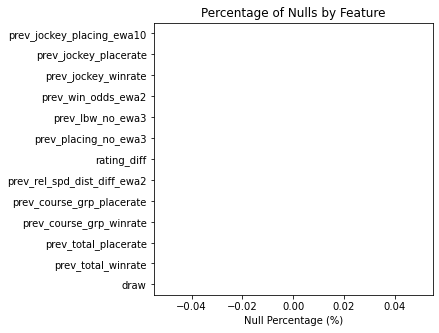

In [20]:
null_features = df_merged[(df_merged['date']>'2016-09-01')][features].isnull().sum() \
                    / len(df_merged[(df_merged['date']>'2016-09-01')]) * 100

fig, ax = plt.subplots(figsize=(5,5))

null_features.plot.barh()
plt.title('Percentage of Nulls by Feature')
plt.xlabel('Null Percentage (%)')
plt.show()

Chart below shows correlations between all selected features vs. target attributes as well as against each other

Apart from draw all attributes have correlation amongst each other particularly for win and place attributes. Feature selection will be done through modelling process

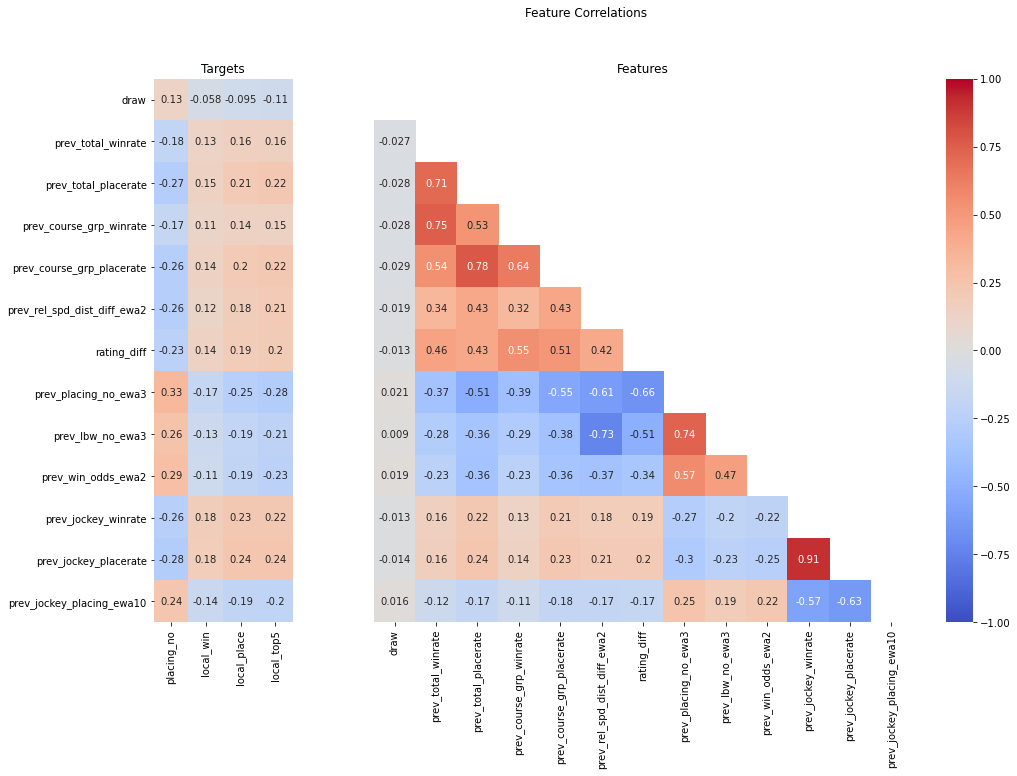

In [24]:
fig, ax = plt.subplots(figsize=(16,10), ncols = 2, gridspec_kw=dict(width_ratios=[3,14.5]))
corr_plot = df_merged.corr()

target_plot = corr_plot.filter(items=['placing_no', 'local_win', 'local_place', 'local_top5'], axis=1) \
                            .filter(items=features,axis=0)

sns.heatmap(target_plot, annot = True, cmap='coolwarm', vmin= -1, vmax = 1, ax = ax[0], cbar=False)

feature_plot = corr_plot.filter(items=features, axis=1) \
                            .filter(items=features,axis=0)
mask = np.triu(np.ones_like(feature_plot, dtype=np.bool))

sns.heatmap(feature_plot, annot = True, cmap='coolwarm', vmin= -1, vmax = 1, ax = ax[1], 
            yticklabels = False, mask=mask) 

plt.suptitle('Feature Correlations')
ax[0].set_title('Targets')
ax[1].set_title('Features')

plt.show()

In [25]:
placing_class_d = {1:'win', 2:'place', 3:'place', 4:'top 5', 5:'top 5'}
df_merged['placing_class'] = df_merged['placing_no'].apply(lambda x:placing_class_d[x] if x in placing_class_d \
                                                          else 'other')

In [26]:
df_merged.to_csv('final_merged_features.csv', index=False)

### 3.2 Model Generation

In [28]:
import warnings
warnings.simplefilter('ignore')

Separate training and testing datasets by date to avoid any potential peeking into testing data which may occur if random sampling was used
- Training data 2016-09-01 to 2019-09-01
- Testing data 2019-09-01 and onwards

Three target variables generated for win, place and top 5

In [39]:
df_features = df_merged[['horse_id', 'date', 'race_id', 'local_win', 'local_place',
                         'local_top5','placing_no', 'placing_class'] + features]

X_train = df_features[(df_features['date']>='2016-09-01') & (df_features['date']<'2019-09-01')][features]
y_win_train = df_features[(df_features['date']>='2016-09-01') & (df_features['date']<'2019-09-01')]['local_win']
y_place_train = df_features[(df_features['date']>='2016-09-01') & (df_features['date']<'2019-09-01')]['local_place']
y_top5_train = df_features[(df_features['date']>='2016-09-01') & (df_features['date']<'2019-09-01')]['local_top5']
y_class_train = df_features[(df_features['date']>='2016-09-01') & (df_features['date']<'2019-09-01')]['placing_class']

X_test = df_features[(df_features['date']>='2019-09-01')][features]
y_win_test= df_features[(df_features['date']>='2019-09-01')]['local_win']
y_place_test = df_features[(df_features['date']>='2019-09-01')]['local_place']
y_top5_test = df_features[(df_features['date']>='2019-09-01')]['local_top5']
y_class_test = df_features[(df_features['date']>='2019-09-01')]['placing_class']

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_validate
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LassoCV
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn import metrics

`train_models` function performs generates preliminary models using 5-fold cross validation
- X_train - training dataset features
- y_train - training dataset target
- models - list of models to try
- title - graph title

In [35]:
def train_models(X_train, y_train, models, title):
    CV = 5
    cv_df = pd.DataFrame(index=range(CV * len(models)))
    model_d = {}
    scoring = ['balanced_accuracy', 'precision']
    for model in models:
        model_name = model.__class__.__name__
        accuracies = cross_validate(model, X_train, y_train, scoring = scoring, cv=CV)
        model_d[model_name] = pd.DataFrame.from_dict(accuracies)
        model_d[model_name].columns = model_d[model_name].columns.str.lstrip('test_')
        model_d[model_name]['model_name'] = model_name.replace("Classifier", "")
        model_d[model_name]['fold_idx'] = np.arange(len(model_d[model_name]))

    cv_df = pd.concat(model_d.values(),ignore_index=True)
    
    fig, ax = plt.subplots(figsize=(10,5), ncols=2)
    
    for i, score in enumerate(scoring):
        b_plot = sns.boxplot(x='model_name', y= score, data=cv_df, ax=ax[i])
        s_plot = sns.stripplot(x='model_name', y= score, data=cv_df, 
                      size=8, jitter=True, edgecolor="gray", linewidth=2, ax=ax[i])
        ax[i].set_xticklabels(b_plot.get_xticklabels(), rotation=45)
        ax[i].set_ylabel(score)
        ax[i].set_xlabel('models')
        ax[i].set_title(score)
    
    plt.suptitle(title)
    plt.show()
    
    display(cv_df.groupby('model_name')[scoring].mean().reset_index())
    
    return cv_df

In [36]:
default_models = [
    DummyClassifier(strategy="most_frequent"),
    RandomForestClassifier(n_estimators=100, min_samples_split=500, random_state=0, class_weight='balanced'),
    LinearSVC(class_weight='balanced', random_state=0),
    LogisticRegression(class_weight='balanced', random_state=0),
    svm.SVC(kernel='rbf', class_weight='balanced')
]

Key evaluation metrics are balanced accuracy and precision due to imbalanced dataset and nature of betting problem wants to optimise correct predictions from guesses denoted as precision

Preliminary win models show similar balanced accuracy performance with random forest performing slightly better

Win class ratio = 1:12.16


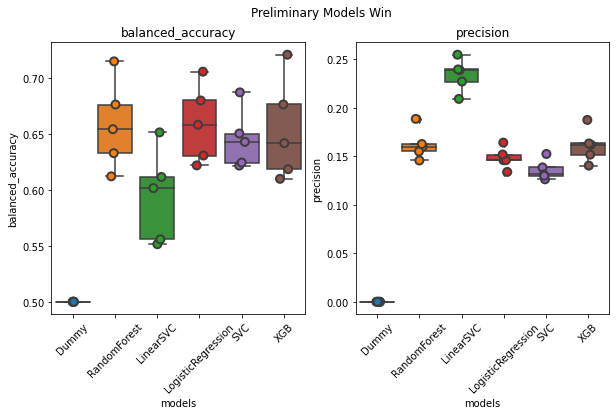

,model_name,balanced_accuracy,precision
0,Dummy,0.500000,0.000000
1,LinearSVC,0.594372,0.233905
2,LogisticRegression,0.659296,0.148378
3,RandomForest,0.658096,0.162359
4,SVC,0.645332,0.135714
5,XGB,0.653482,0.160994


In [42]:
win_models = default_models + \
            [xgb.XGBClassifier(objective="binary:logistic", random_state=0, scale_pos_weight=10)]

print('Win class ratio = 1:{0:.1f}'.format(1/(y_win_train.sum()/len(y_win_train))))
df_prelim_win = train_models(X_train, y_win_train, win_models, 'Preliminary Models Win')

Preliminary models for place prediction are similar to win prediction with random forest slightly out performing others, precision score naturally increases over win as class weights become more balanced

Place class ratio = 1:4.06


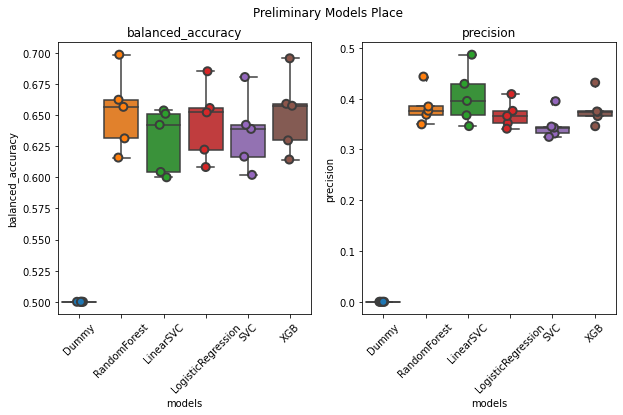

,model_name,balanced_accuracy,precision
0,Dummy,0.500000,0.000000
1,LinearSVC,0.630245,0.404966
2,LogisticRegression,0.644712,0.368794
3,RandomForest,0.652909,0.384440
4,SVC,0.636037,0.347858
5,XGB,0.651216,0.378387


In [43]:
place_models = default_models + \
            [xgb.XGBClassifier(objective="binary:logistic", random_state=0, scale_pos_weight=3)]

print('Place class ratio = 1:{0:.1f}'.format(1/(y_place_train.sum()/len(y_place_train))))
df_prelim_place = train_models(X_train, y_place_train, place_models, 'Preliminary Models Place')

Model for top 5 placing shows similar performance to win and place, with precision again naturally increasing

Top 5 class ratio = 1:2.4


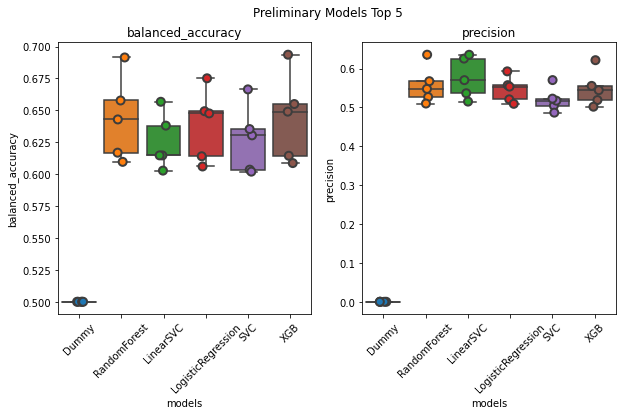

,model_name,balanced_accuracy,precision
0,Dummy,0.500000,0.000000
1,LinearSVC,0.625390,0.576504
2,LogisticRegression,0.638426,0.546688
3,RandomForest,0.643711,0.557488
4,SVC,0.627540,0.520239
5,XGB,0.644132,0.548364


In [46]:
top5_models = default_models + \
            [xgb.XGBClassifier(objective="binary:logistic", random_state=0, scale_pos_weight=1.5)]

print('Top 5 class ratio = 1:{0:.1f}'.format(1/(y_top5_train.sum()/len(y_top5_train))))
df_prelim_place = train_models(X_train, y_top5_train, top5_models, 'Preliminary Models Top 5')

`lasso_feature` function generates a dataframe of coefficients from lasso classifier to interpret as feature importance
- target - target variable from training dataset
- colname - column name

In [47]:
def lasso_feature(target, colname):
    lasso_clf = LassoCV().fit(X_train, target)

    lasso_coef_d = {'features':features, 'coef':list(lasso_clf.coef_)}
    lasso_coef = pd.DataFrame.from_dict(lasso_coef_d)
    lasso_coef[colname] = lasso_coef['coef'].abs()
    
    return lasso_coef

Jockey placerate is the most important feature for win and place predictions

Place rates seem to provide more information than win rates, try dropping winrates to see if any performance impact on models

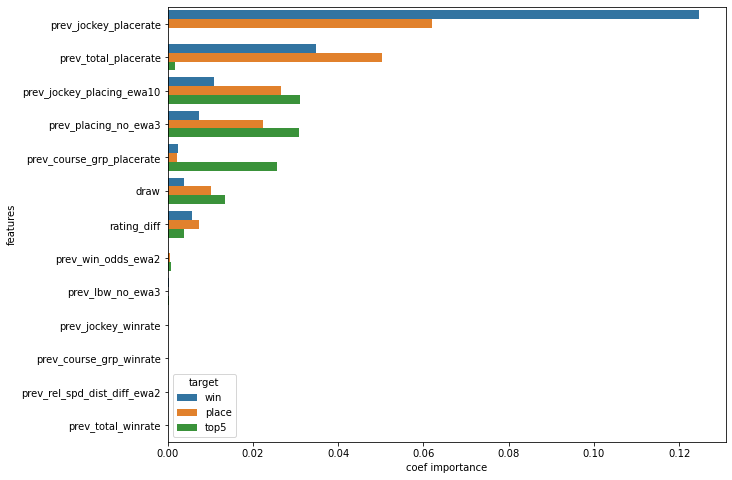

In [52]:
from functools import reduce

lasso_win = lasso_feature(y_win_train, 'win')
lasso_place = lasso_feature(y_place_train, 'place')
lasso_top5 = lasso_feature(y_top5_train, 'top5')

lasso_dfs = [lasso_win, lasso_place, lasso_top5]
lasso_plot = reduce(lambda  left,right: pd.merge(left,right,on='features', how='inner'), lasso_dfs)

lasso_plot = pd.melt(lasso_plot, id_vars=['features'], 
                          value_vars=['win', 'place', 'top5'])
lasso_plot = lasso_plot.rename(columns = {'variable':'target', 'value':'coef importance'})

fig, ax = plt.subplots(figsize=(10,8))
sns.barplot(x='coef importance', y='features', hue='target', 
            data=lasso_plot.sort_values('coef importance', ascending=False))
plt.show()

Preliminary models with winrates dropped do not show any significant difference to prior models, winrates will be kept as random forest classifier will randomly select subset of features to use 

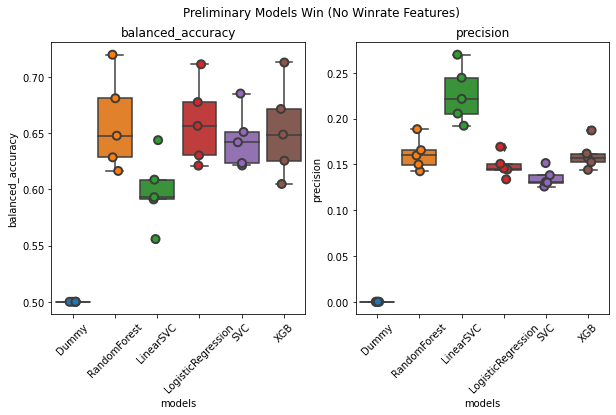

,model_name,balanced_accuracy,precision
0,Dummy,0.500000,0.000000
1,LinearSVC,0.598469,0.226662
2,LogisticRegression,0.659346,0.148633
3,RandomForest,0.658697,0.161182
4,SVC,0.644577,0.135248
5,XGB,0.652686,0.160486


In [53]:
win_models = default_models + \
            [xgb.XGBClassifier(objective="binary:logistic", random_state=0, scale_pos_weight=10)]

df_win_filter = train_models(X_train[X_train.columns[~X_train.columns.str.endswith('winrate')]], y_win_train, 
                             win_models, 'Preliminary Models Win (No Winrate Features)')

Perform gridsearch on random forst classifier for win prediction

In [90]:
scoring = ['precision', 'balanced_accuracy']
param_grid = {'max_depth': list(range(3,10)),
              'max_features': list(range(3,10))}

rf_clf = GridSearchCV(RandomForestClassifier(n_estimators=100, random_state=0, 
                                             min_samples_split=500, class_weight='balanced'), 
                   param_grid, scoring=scoring, refit='balanced_accuracy', verbose=True, n_jobs=-1)

rf_win = rf_clf.fit(X_train, y_win_train)
rf_win_clf = rf_win.best_estimator_

Fitting 5 folds for each of 49 candidates, totalling 245 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 245 out of 245 | elapsed:  1.7min finished


`clf_results` function generates results dataframe from gridsearch cross validation function
- clf - gridsearch cv classifier

In [55]:
def clf_results(clf):
    df = pd.DataFrame.from_dict(clf.cv_results_)
    df = df[df.columns[df.columns.str.startswith(('param_', 'mean_test'))]]
    df.columns = [re.sub(r'^param_|^mean_test_','',col) for col in df.columns]
    return df

`rf_plot` function generates random forest facet grid plot of balanced accuracy and precision across changing parameters
- gridsearch_clf - gridsearch classifier
- clf_result - clf results dataframe output from `clf_results` function

In [58]:
def rf_plot(gridsearch_clf, clf_result):
    rf_plot = pd.melt(clf_result, id_vars=['max_depth', 'max_features'], 
                          value_vars=['balanced_accuracy', 'precision'])
    rf_plot = rf_plot.rename(columns={'variable':'metric', 'value':'score'})
    
    g = sns.FacetGrid(rf_plot, col='max_features', col_wrap=4,
                  hue='metric', margin_titles=True, legend_out=True)

    g = (g.map(sns.lineplot, 'max_depth', 'score') \
        .add_legend())
    g.fig.set_size_inches(15,8)
    plt.show()

    print("Balanced Accuracy = {0:.2f}%".format(gridsearch_clf.best_score_ * 100))
    print("Precision = {0:.2f}%".format(clf_result.iloc[gridsearch_clf.best_index_]['precision'] * 100))
    print("Estimator Parameters = {0}".format(gridsearch_clf.best_estimator_))

`feature_importance_plot` function generates feature importances from random forest
- fitted_model - random forest model

In [61]:
def feature_importance_plot(fitted_model):
    fi_d = {'features': features, 'importance':fitted_model.feature_importances_}
    df_fi = pd.DataFrame.from_dict(fi_d)
    df_fi.sort_values('importance').plot.barh('features','importance')

    plt.show()
    return df_fi

Results from grid search for win prediction, showed similar performance across hyper parameters

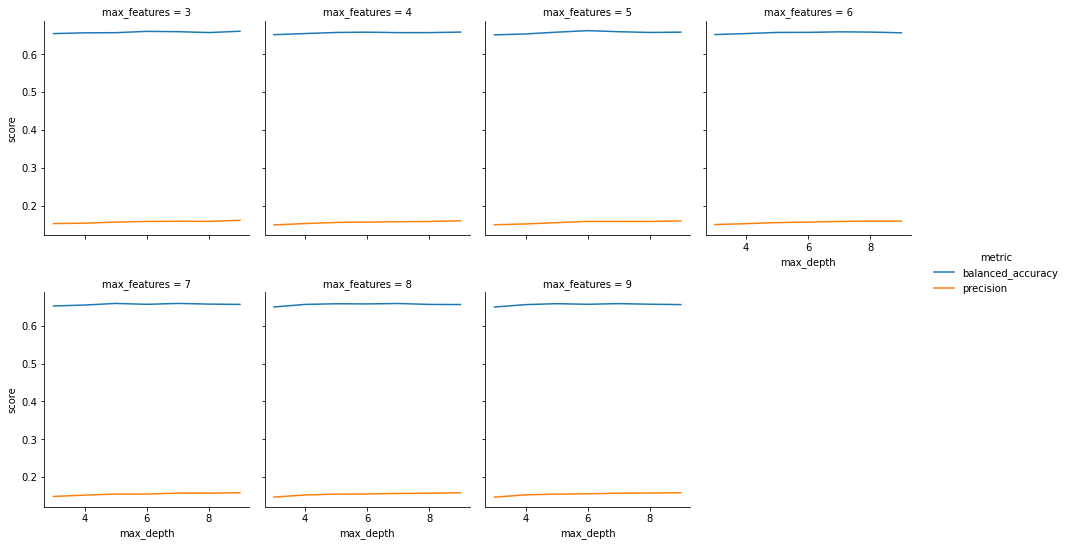

Balanced Accuracy = 66.26%
Precision = 15.84%
Estimator Parameters = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=6, max_features=5,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


In [59]:
rf_win_results = clf_results(rf_win)

rf_plot(rf_win, rf_win_results)

In [91]:
rf_place = rf_clf.fit(X_train, y_place_train)
rf_place_clf = rf_place.best_estimator_

Fitting 5 folds for each of 49 candidates, totalling 245 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 245 out of 245 | elapsed:  1.7min finished


Results from grid search for place prediction, showed similar performance across hyper parameters

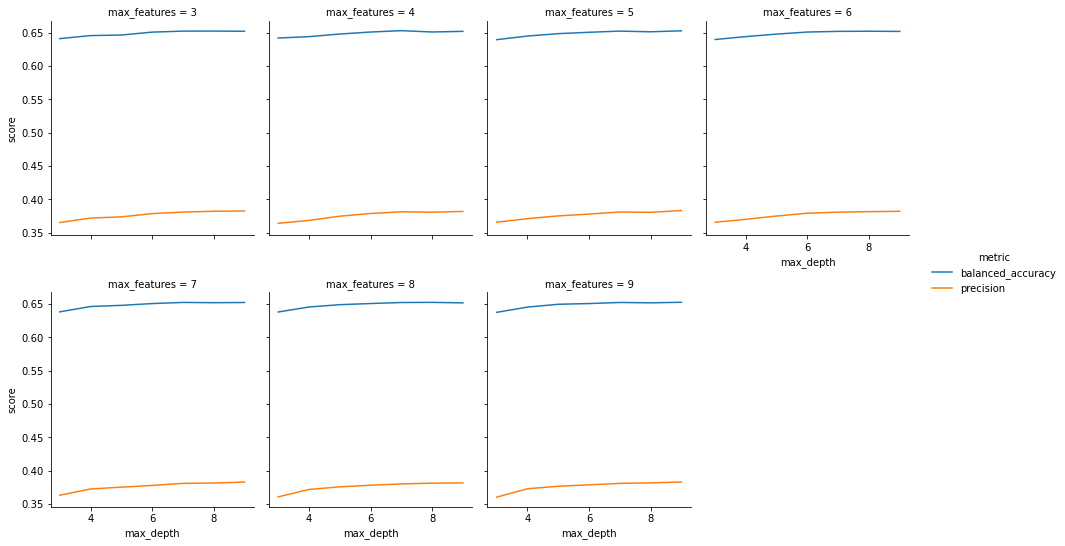

Balanced Accuracy = 65.28%
Precision = 38.11%
Estimator Parameters = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=7, max_features=4,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


In [63]:
rf_place_results = clf_results(rf_place)

rf_plot(rf_win, rf_place_results)

In [94]:
rf_top5 = rf_clf.fit(X_train, y_top5_train)
rf_top5_clf = rf_top5.best_estimator_

Fitting 5 folds for each of 49 candidates, totalling 245 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 245 out of 245 | elapsed:  1.7min finished


Results from grid search for top 5 prediction, showed model improvement for higher max depth

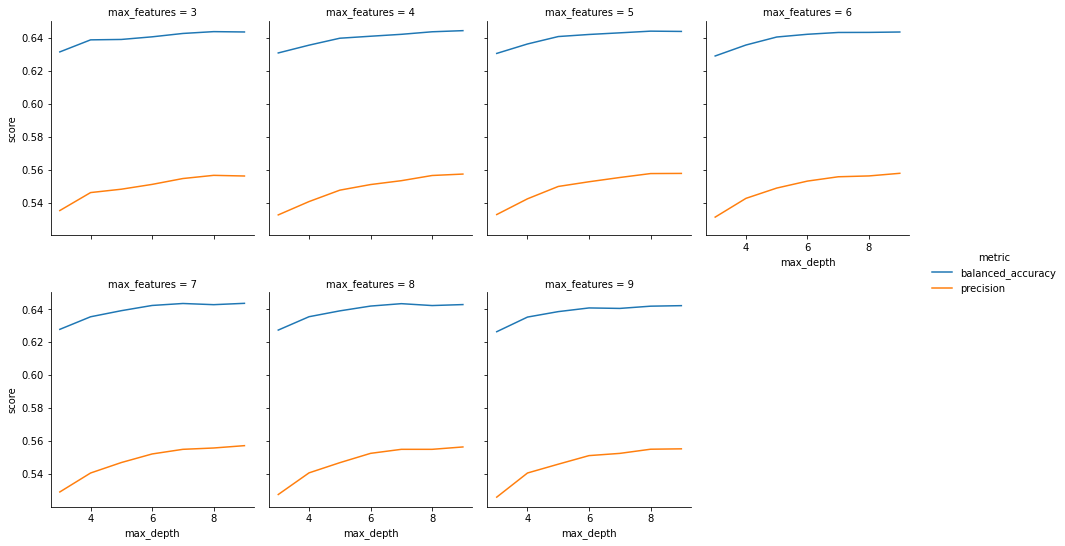

Balanced Accuracy = 64.43%
Precision = 55.73%
Estimator Parameters = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=9, max_features=4,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


In [65]:
rf_top5_results = clf_results(rf_top5)

rf_plot(rf_win, rf_top5_results)

### 3.3 Model Evaluation
#### 3.3.1 Validation Dataset Evaluation
Training data was split into training and validation for final model validation using random forest classifier with parameters generated from grid search best estimator

In [66]:
X_train_tuned, X_val_tuned = train_test_split(X_train, test_size = 0.25)
y_train_win_t = y_win_train[X_train_tuned.index]
y_train_place_t = y_place_train[X_train_tuned.index]
y_train_top5_t = y_top5_train[X_train_tuned.index]

y_val_win = y_win_train[X_val_tuned.index]
y_val_place = y_place_train[X_val_tuned.index]
y_val_top5 = y_top5_train[X_val_tuned.index]

`confusion_matrix` function draws a confusion matrix plot
- model - fitted model
- X_val - validation data for prediction
- y_true - true labels of target
- title - plot title

In [118]:
def confusion_matrix(model, X_val, y_true, title):
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)[:,1]
    df_val = X_val.copy()
    df_val['y_true'] = y_true
    df_val['y_pred'] = y_pred
    df_val['y_proba'] = y_proba
    
    cm_ct = pd.crosstab(df_val['y_true'], df_val['y_pred'])
    sns.heatmap(cm_ct, annot=True, fmt='d',cmap='Blues')
    plt.title(title)
    plt.show()
    
    print("Precision = {0:.2f}%".format(metrics.precision_score(df_val['y_true'], df_val['y_pred']) * 100))
    print("Balanced Accuracy = {0:.2f}%".format(metrics.balanced_accuracy_score(df_val['y_true'], df_val['y_pred']) * 100))
    
    return df_val

Fit win, place and top 5 models using respective best estimators generated from gridsearch. Classifier modified to increase number of trees in classifier for final model validation

In [ ]:
rf_win_tuned = rf_win_clf.set_params(n_estimators=1000).fit(X_train_tuned, y_train_win_t)
rf_place_tuned = rf_place_clf.set_params(n_estimators=1000).fit(X_train_tuned, y_train_place_t)
rf_top5_tuned = rf_top5_clf.set_params(n_estimators=1000).fit(X_train_tuned, y_train_top5_t)

Individual models show similar performance to results from gridsearch and will be taken forwards

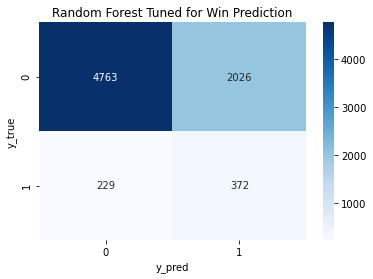

Precision = 15.51%
Balanced Accuracy = 66.03%


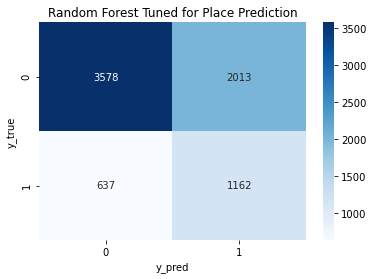

Precision = 36.60%
Balanced Accuracy = 64.29%


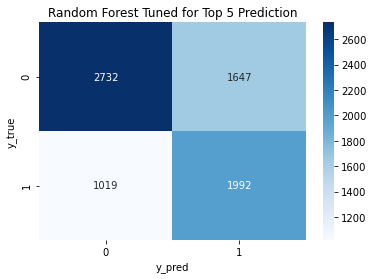

Precision = 54.74%
Balanced Accuracy = 64.27%


In [121]:
rf_win_eval = confusion_matrix(rf_win_tuned, X_val_tuned, y_val_win, 
                                          'Random Forest Tuned for Win Prediction')

rf_place_eval = confusion_matrix(rf_place_tuned, X_val_tuned, y_val_place, 
                                          'Random Forest Tuned for Place Prediction')

rf_top5_eval = confusion_matrix(rf_top5_tuned, X_val_tuned, y_val_top5, 
                                          'Random Forest Tuned for Top 5 Prediction')

Feature importance across different models show top 5 features across all models are the same with varying feature importance weighting

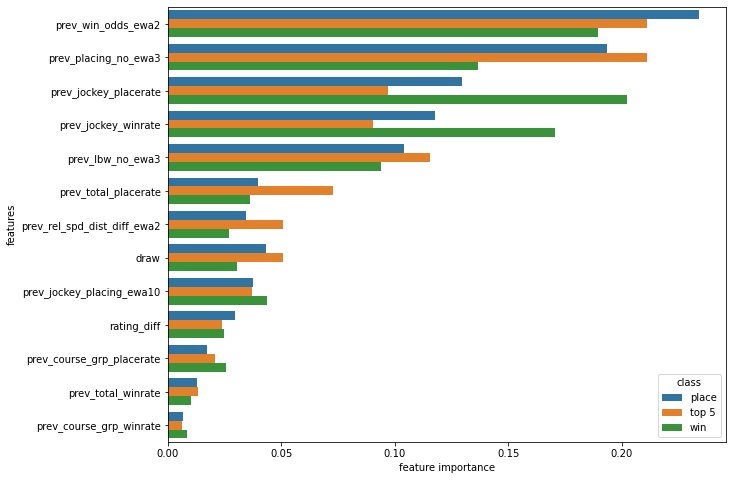

In [106]:
fi_d = {'features': features, 'win':rf_win_tuned.feature_importances_,
       'place':rf_place_tuned.feature_importances_, 'top 5':rf_top5_tuned.feature_importances_}
df_fi = pd.DataFrame.from_dict(fi_d)

fi_plot = pd.melt(df_fi, id_vars=['features'], 
                          value_vars=['win', 'place', 'top 5'])
fi_plot = fi_plot.rename(columns = {'variable':'class', 'value':'feature importance'})

fig, ax = plt.subplots(figsize=(10,8))
sns.barplot(x='feature importance', y='features', hue='class', 
            data=fi_plot.sort_values('feature importance', ascending=False))
plt.show()

#### Combined Ordinal Classification
Combine three binary classification models according to Frank and Hall to predict individual classes within a rank ordered set

In [135]:
train_eval = df_features[(df_features['date']>='2016-09-01') & (df_features['date']<'2019-09-01')]

eval_dfs = [train_eval, rf_win_eval[['y_pred','y_proba']].rename(columns={'y_pred':'win_pred', 'y_proba':'win_proba'}),
           rf_place_eval[['y_pred','y_proba']].rename(columns={'y_pred':'place_pred', 'y_proba':'place_proba'}),
           rf_top5_eval[['y_pred','y_proba']].rename(columns={'y_pred':'top5_pred', 'y_proba':'top5_proba'}),]
train_eval = reduce(lambda  left,right: pd.merge(left,right,left_index=True, right_index=True), eval_dfs)

In [258]:
train_eval_FH = train_eval.copy()
train_eval_FH['win class'] = train_eval_FH['win_proba']
train_eval_FH['place class'] = abs(train_eval_FH['place_proba'] - train_eval_FH['win_proba'])
train_eval_FH['top 5 class'] = abs(train_eval_FH['top5_proba']  - train_eval_FH['place_proba'])
train_eval_FH['other class'] = (1 - train_eval_FH['top5_proba'])

train_eval['win class'] = train_eval['win_proba']
train_eval['place class'] = (1 - train_eval['win_proba']) * train_eval['place_proba']
train_eval['top 5 class'] = (1 - train_eval['place_proba']) * train_eval['top5_proba']
train_eval['other class'] = (1 - train_eval['top5_proba'])

In [138]:
def returncolname(row, colnames):
    return colnames[np.argmax(row.values)].replace(" class", "")

class_cols = ['win class', 'place class', 'top 5 class', 'other class']
train_eval['class_pred'] = train_eval[class_cols].apply(lambda x: returncolname(x, class_cols), axis=1)

Frank and Hall and Cardoso and Costa probability calculations generate the same confusion matrix. This is believed to be because win, place and top 5 models are very similar therefore calculating the probability differences for the individual place and top 5 would always be overshadowed by either win or other so no predictions are associated with these two classes

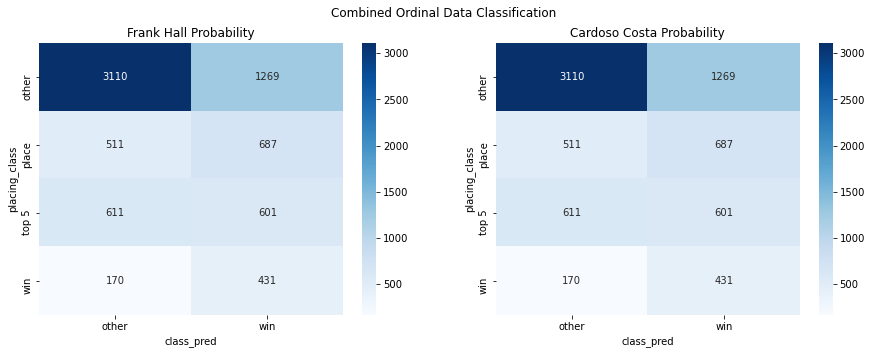

In [260]:
fig, ax = plt.subplots(figsize=(15,5), ncols = 2)

eval_ct_FH = pd.crosstab(train_eval_FH['placing_class'], train_eval_FH['class_pred'])
sns.heatmap(eval_ct_FH, annot=True, fmt='d',cmap='Blues', ax=ax[0])

eval_ct = pd.crosstab(train_eval['placing_class'], train_eval['class_pred'])
sns.heatmap(eval_ct, annot=True, fmt='d',cmap='Blues', ax=ax[1])

ax[0].set_title('Frank Hall Probability')
ax[1].set_title('Cardoso Costa Probability')

plt.suptitle('Combined Ordinal Data Classification')
plt.show()

`max_threshold` function returns column name with maximum values if exceeding threshold
- row - column values to compare
- colnames - column names to assign
- threshold - threshold to exceed

In [175]:
def max_threshold(row, colnames, threshold):
    max_class = colnames[np.argmax(row.values)].replace(" class", "") \
                    if np.max(row.values) >= threshold else "other"
    return max_class

class_cols = ['win', 'place', 'top 5']
train_eval['class_max_prob'] = train_eval[['win_proba', 'place_proba', 'top5_proba']] \
                                .apply(lambda x: max_threshold(x, class_cols, 0.5), axis=1)

Confusion matrix taking maximum probability across three models shows poor results as expected as binary classification problem translated into a multiclass classification problem 

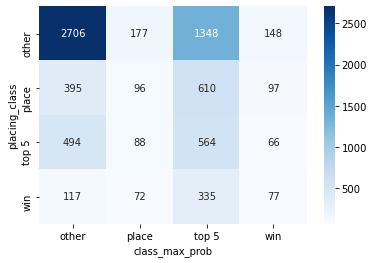

Balanced Accuracy = 32.29%


In [263]:
eval_max_ct = pd.crosstab(train_eval['placing_class'], train_eval['class_max_prob'])
sns.heatmap(eval_max_ct, annot=True, fmt='d',cmap='Blues')

plt.show()

print("Balanced Accuracy = {0:.2f}%".format(metrics.balanced_accuracy_score(train_eval['placing_class'], 
                                                                            train_eval['class_max_prob']) * 100))

#### 3.3.3 Testing Dataset Evaluation
Train model on full training data set and evaluate on hold out testing dataset

In [178]:
rf_win_final = rf_win_clf.set_params(n_estimators=1000).fit(X_train, y_win_train)
rf_place_final = rf_place_clf.set_params(n_estimators=1000).fit(X_train, y_place_train)

Across the testing dataset, similar performance is observed when compared to results from validation showing model stability

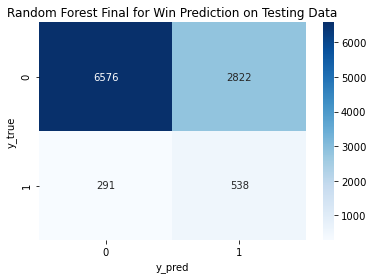

Precision = 16.01%
Balanced Accuracy = 67.43%


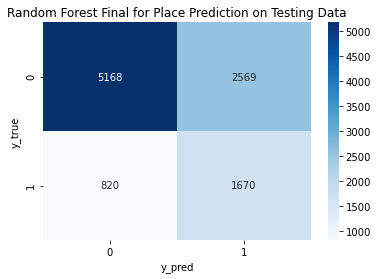

Precision = 39.40%
Balanced Accuracy = 66.93%


In [180]:
win_results = confusion_matrix(rf_win_final, X_test, y_win_test, 
                                          'Random Forest Final for Win Prediction on Testing Data')

place_results = confusion_matrix(rf_place_final, X_test, y_place_test, 
                                          'Random Forest Final for Place Prediction on Testing Data')

In [300]:
final_results = df_merged[(df_features['date']>='2019-09-01')]

results_dfs = [final_results, 
               win_results[['y_pred','y_proba']].rename(columns={'y_pred':'win_pred', 'y_proba':'win_proba'}),
               place_results[['y_pred','y_proba']].rename(columns={'y_pred':'place_pred', 'y_proba':'place_proba'})]
final_results = reduce(lambda  left,right: pd.merge(left,right,left_index=True, right_index=True), results_dfs)

In [301]:
final_results['max_winprob_race'] = final_results.groupby('race_id')['win_proba'].transform('max')
final_results['max_placeprob_race'] = final_results.groupby('race_id')['place_proba'].transform('max')

max3_placeproba = final_results.groupby('race_id')['place_proba'].apply(lambda x: x.nlargest(3))\
                                .reset_index().set_index('level_1')['place_proba'].rename('max3_placeproba', inplace=True)
final_results = pd.merge(final_results, max3_placeproba, 
                         left_index=True, right_index=True, how = 'left')
final_results['max3_placeproba'] = final_results['max3_placeproba'].fillna(0)

final_results['race_best_odds'] = final_results.groupby('race_id')['win_odds'].transform('min')
final_results['best_odds_win'] = final_results.apply(lambda row: 1 if row['win_odds'] == row['race_best_odds'] \
                                                        else 0, axis=1)

In [303]:
df_results_eval = final_results.sort_values('race_id')[['race_id','placing_no', 'win_odds', 'best_odds_win',
                                                        'local_win', 'win_proba', 'max_winprob_race', 'local_place', 
                                                        'place_proba', 'max_placeprob_race', 'max3_placeproba']]

`threshold_eval` function assigns win and place based on selected cut off threshold for probability
- results - input dataframe
- threshold - probability threshold cut-off 

In [304]:
def threshold_eval(results, threshold=0.5):
    df_eval = results.copy()
    df_eval['win_race'] = df_eval.apply(lambda row: 1 if (row['win_proba'] == row['max_winprob_race']) \
                                                        & (row['win_proba']>=threshold) else 0, axis=1)
    df_eval['place_race'] = df_eval.apply(lambda row: 1 if row['max3_placeproba']>0 else 0, axis=1)
    return df_eval

`race_cm` function groups by race and assigns prediction to highest probability horse in the race
- results - input dataframe
- threshold - probability threshold cutoff

In [252]:
def race_cm(results, threshold):
    fig, ax = plt.subplots(figsize=(15,5), ncols= 3)

    df_eval = threshold_eval(results, threshold)
    
    win_ct = pd.crosstab(df_eval['local_win'], df_eval['win_race'])
    sns.heatmap(win_ct, annot=True, fmt='d',cmap='Blues', ax=ax[0])
    
    place_ct = pd.crosstab(df_eval['local_place'], df_eval['place_race'])
    sns.heatmap(place_ct, annot=True, fmt='d',cmap='Blues', ax=ax[1])
    
    odds_ct = pd.crosstab(df_eval['local_win'], df_eval['best_odds_win'])
    sns.heatmap(odds_ct, annot=True, fmt='d',cmap='Blues', ax=ax[2])
    
    ax[0].set_title('Win Race Result for {0}'.format(threshold))
    ax[1].set_title('Place Race Result for {0}'.format(threshold))
    ax[2].set_title('Naive Result for choosing Best Odds')
    plt.show()
    
    print("Win Balanced Accuracy = {0:.2f}%".format(metrics.balanced_accuracy_score(df_eval['local_win'], 
                                                df_eval['win_race'])*100))
    print("Win Precision = {0:.2f}%".format(metrics.precision_score(df_eval['local_win'], 
                                                df_eval['win_race'])*100))
    print("Place Balanced Accuracy = {0:.2f}%".format(metrics.balanced_accuracy_score(df_eval['local_place'], 
                                                df_eval['place_race'])*100))
    print("Place Precision = {0:.2f}%".format(metrics.precision_score(df_eval['local_place'], 
                                                df_eval['place_race'])*100))
    print("Best Odds Accuracy = {0:.2f}%".format(metrics.balanced_accuracy_score(df_eval['local_win'], 
                                                df_eval['best_odds_win'])*100))
    print("Best Odds Precision = {0:.2f}%".format(metrics.precision_score(df_eval['local_win'], 
                                                df_eval['best_odds_win'])*100))

Naive estimator of selecting result with best odds can be seen to outperform our win prediction

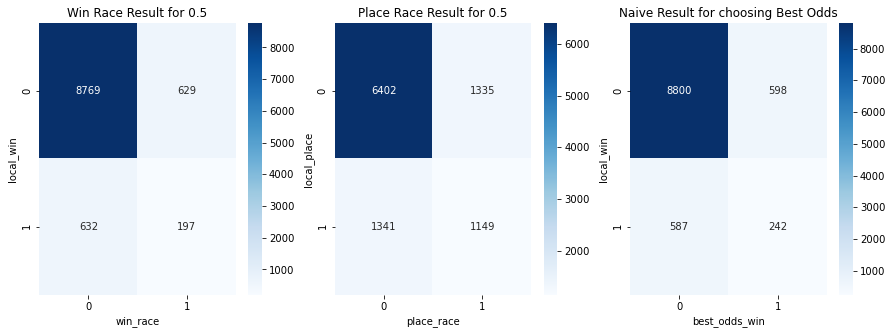

Win Balanced Accuracy = 58.54%
Win Precision = 23.85%
Place Balanced Accuracy = 64.44%
Place Precision = 46.26%
Best Odds Accuracy = 61.41%
Best Odds Precision = 28.81%


In [305]:
race_cm(df_results_eval, 0.5)

Evaluating predicted values vs actual placing shows both win and race predictions are extremely, therefore future model development should revert back to feature engineering to identify root cause behind this similarity and if any additional features should be added or taken away

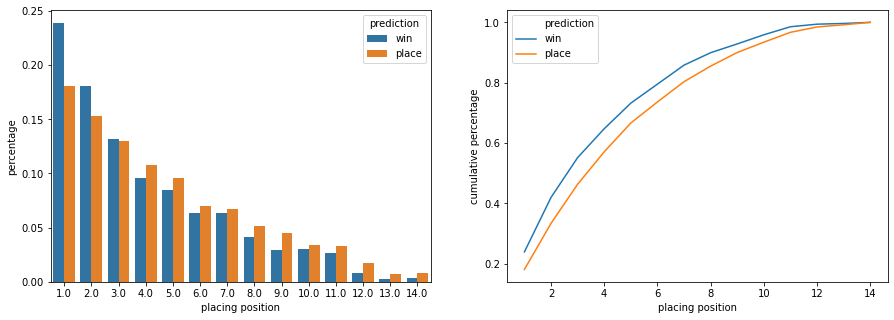

In [311]:
df_threshold = threshold_eval(df_results_eval, 0.5)
df_threshold = df_threshold.groupby('placing_no').agg({'win_race':'sum', 'place_race':'sum'}).reset_index()

placing_plot = pd.melt(df_threshold, id_vars=['placing_no'], value_vars=['win_race', 'place_race']) \
                .rename(columns={'variable':'prediction', 'value':'count'})
placing_plot['percentage'] = placing_plot['count'] / placing_plot.groupby('prediction')['count'].transform('sum')
placing_plot['cum_percentage'] = placing_plot.groupby('prediction')['percentage'].cumsum()
placing_plot['prediction'] = placing_plot['prediction'].apply(lambda x: x.replace('_race',''))

fig, ax = plt.subplots(figsize=(15,5), ncols=2)

sns.barplot(data=placing_plot, x='placing_no', y='percentage', hue='prediction', ax=ax[0])
sns.lineplot(data=placing_plot, x='placing_no', y='cum_percentage', hue='prediction', ax=ax[1])

ax[0].set_xlabel('placing position')
ax[1].set_xlabel('placing position')
ax[1].set_ylabel('cumulative percentage')

plt.show()

In [236]:
thresholds = []
win_bal_accuracy = []
win_precision = []
win_predictions = []
place_bal_accuracy = []
place_precision = []
place_predictions = []

for thr in np.linspace(0.5, 0.95, 10):
    df_eval = threshold_eval(df_results_eval, thr)
    thresholds.append(thr)
    win_bal_accuracy.append(metrics.balanced_accuracy_score(df_eval['local_win'], df_eval['win_race'])*100)
    win_precision.append(metrics.precision_score(df_eval['local_win'], df_eval['win_race'])*100)
    win_predictions.append(df_eval['win_race'].sum())
    place_bal_accuracy.append(metrics.balanced_accuracy_score(df_eval['local_place'], df_eval['place_race'])*100)
    place_precision.append(metrics.precision_score(df_eval['local_place'], df_eval['place_race'])*100)
    place_predictions.append(df_eval['place_race'].sum())

threshold_results = pd.DataFrame.from_dict({'threshold': thresholds, 'win_accuracy': win_bal_accuracy,
                                           'win_precision':win_precision, 'win_predictions': win_predictions,
                                            'place_accuracy':place_bal_accuracy, 'place_precision':place_precision,
                                           'place_predictions':place_predictions})

Win and place predictions when adjusting for different thresholds show a small increase in precision when threshold is increased however very few predictions are made in this case. 

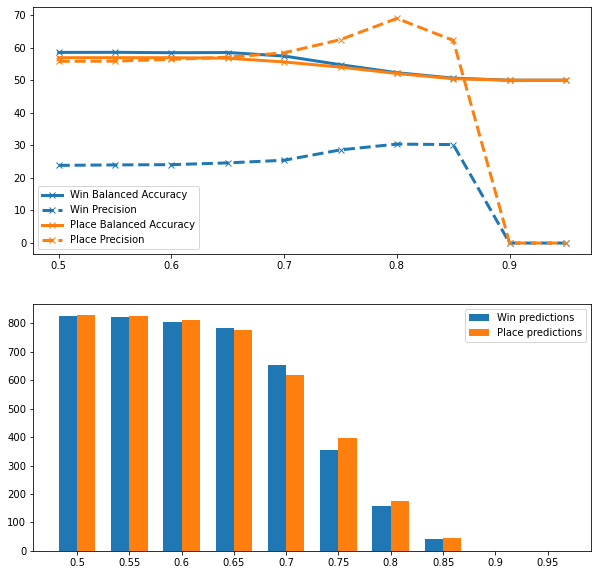

In [239]:
fig, ax = plt.subplots(figsize = (10,10), nrows=2)

win_acc = ax[0].plot(threshold_results['threshold'],threshold_results['win_accuracy'], 
                       label='Win Balanced Accuracy', color = 'tab:blue', lw=3, marker='x')
win_pre = ax[0].plot(threshold_results['threshold'],threshold_results['win_precision'], 
                       label='Win Precision', color = 'tab:blue', lw=3, marker='x', linestyle='dashed')

plc_acc = ax[0].plot(threshold_results['threshold'],threshold_results['place_accuracy'], 
                       label='Place Balanced Accuracy', color = 'tab:orange', lw=3, marker='x')
plc_pre = ax[0].plot(threshold_results['threshold'],threshold_results['place_precision'], 
                       label='Place Precision', color = 'tab:orange', lw=3, marker='x', linestyle='dashed')
ax[0].legend()

indices = np.arange(threshold_results['threshold'].count())
width = 0.35

win_bar = ax[1].bar(indices, threshold_results['win_predictions'], 
                   width, label='Win predictions', color = 'tab:blue')
plc_bar = ax[1].bar(indices+width, threshold_results['place_predictions'], 
                width, label='Place predictions', color = 'tab:orange')

ax[1].set_xticks(indices + width / 2)
ax[1].set_xticklabels(list(round(threshold_results['threshold'],2)))

ax[1].legend()
plt.show()

### 3.1.3 Neural Network Investigation
Brief investigation into model performance if a neural network model is used instead

In [152]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [153]:
features_NN = ['draw', 'prev_total_placerate','prev_course_grp_placerate','prev_rel_spd_dist_diff_ewa2', 
               'rating_diff', 'prev_placing_no_ewa3','prev_lbw_no_ewa3', 'prev_win_odds_ewa2',
               'prev_jockey_placerate', 'prev_jockey_placing_ewa10']
X_train_NN = df_features[(df_features['date']>='2016-09-01') & (df_features['date']<'2019-09-01')] \
                [features_NN + ['local_place', 'local_win']]

In [154]:
win_nn = {}

win_nn['X_train'],  win_nn['X_val'], win_nn['y_train'], win_nn['y_val'] = train_test_split(X_train_NN[features_NN], 
                                                                                   X_train_NN['local_win'],
                                                                                   test_size=0.2)

In [155]:
place_nn={}

place_nn['X_train'],  place_nn['X_val'], place_nn['y_train'], place_nn['y_val'] = train_test_split(X_train_NN[features_NN], 
                                                                                   X_train_NN['local_place'],
                                                                                   test_size=0.2)

In [156]:
METRICS = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

BATCH_SIZE = 32
class_weight = {0:1, 1:10}

early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=5)
#mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, min_delta=1e-4, mode='min')

`build_model` function generates the neural network model architecture with 1 input layer, 1 hidden layer and 1 output layer with 36, 18 and 1 nodes respectively
- train_data - training data input

In [157]:
def build_model(train_data, metrics=["accuracy"]):
    model = keras.Sequential([
        keras.layers.Dense(
          units=36,
          activation='relu',
          input_shape=(train_data.shape[-1],)
        ),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.25),
        keras.layers.Dense(
          units=18, activation='relu'
        ),
        keras.layers.Dropout(0.25),
        keras.layers.Dense(units=1, activation='sigmoid'),
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(lr=0.001),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics
    )
    model.summary()
    return model

`fit_nn_model` function fits the previously generated model architecture on training data
- model - neural network model architecture
- nn_dict - dictionary of training data

In [158]:
def fit_nn_model(model, nn_dict):
    history = model.fit(
        nn_dict['X_train'],
        nn_dict['y_train'],
        batch_size=BATCH_SIZE,
        epochs=30,
        validation_data=(nn_dict['X_val'], nn_dict['y_val']),
        shuffle=True,
        class_weight=class_weight,
        callbacks=[early_stopping_monitor, reduce_lr_loss],
        verbose=2
    )
    return history

In [ ]:
win_model_1 = keras.Sequential([
    keras.layers.Dense(
      units=36, activation='relu',
      input_shape=(win_nn['X_train'].shape[-1],)
    ),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(units=1, activation='sigmoid'),
])

In [160]:
win_model_nn = build_model(win_nn['X_train'], metrics=METRICS)
win_history_1 = fit_nn_model(win_model_nn, win_nn)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 36)                396       
_________________________________________________________________
batch_normalization_1 (Batch (None, 36)                144       
_________________________________________________________________
dropout_2 (Dropout)          (None, 36)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 18)                666       
_________________________________________________________________
dropout_3 (Dropout)          (None, 18)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 19        
Total params: 1,225
Trainable params: 1,153
Non-trainable params: 72
___________________________________________________

`plot_metrics` function generates plots of loss and precision across training epochs

In [165]:
def plot_metrics(history):
    metrics =  ['loss', 'precision']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch,  history.history[metric], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        else:
            plt.ylim([0,1])

    plt.legend()

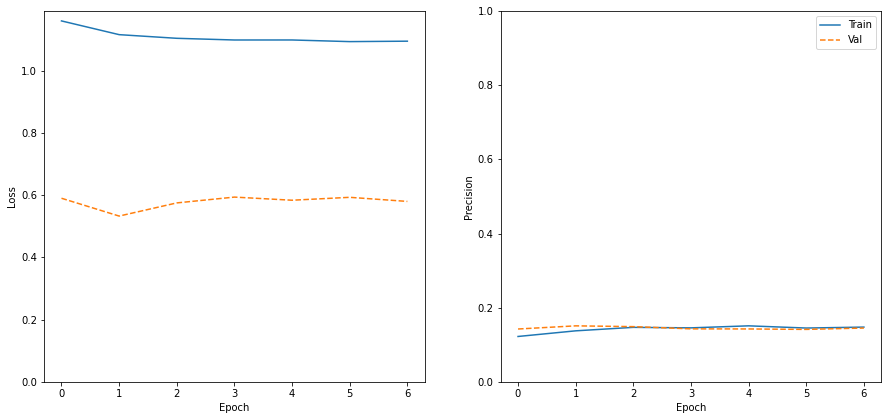

In [166]:
fig, ax = plt.subplots(figsize=(15,15))
plot_metrics(win_history_1)
plt.show()

In [167]:
class_weight = {0:1, 1:3}
place_model_nn = build_model(place_nn['X_train'], metrics=METRICS)
place_history = fit_nn_model(place_model_nn, place_nn)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 36)                396       
_________________________________________________________________
batch_normalization_2 (Batch (None, 36)                144       
_________________________________________________________________
dropout_4 (Dropout)          (None, 36)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 18)                666       
_________________________________________________________________
dropout_5 (Dropout)          (None, 18)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 19        
Total params: 1,225
Trainable params: 1,153
Non-trainable params: 72
___________________________________________________

Both neural network models generated on win and place show similar performance to prior random forest models with weighted accruacy ~65%. Limiting factor for all models are the features

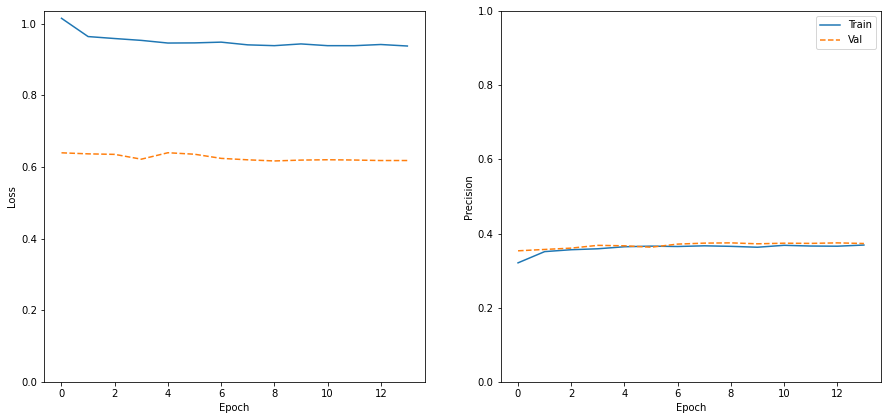

In [265]:
fig, ax = plt.subplots(figsize=(15,15))
plot_metrics(place_history)
plt.show()